# Stop counts by stop purpose groups

Date: April 4, 2023

In [1]:
import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly
import plotly.express as px
import pandas as pd

In [2]:
plotly.offline.init_notebook_mode()
pg_engine = create_engine("postgresql://postgres@db:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

In [3]:
from enum import Enum

color_map = {
    "Black": px.colors.qualitative.Pastel[9],
    "White": px.colors.qualitative.Pastel[0],
    "Asian": px.colors.qualitative.Pastel2[5],
    "Hispanic": px.colors.qualitative.Antique[2],
    "Native American": px.colors.qualitative.Set2[2],
    "Other": px.colors.qualitative.Set3[2],
}

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION = 1  # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION = 2  # Safety Violation
    DRIVING_WHILE_IMPAIRED = 3  # Safety Violation
    SAFE_MOVEMENT_VIOLATION = 4  # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION = 5  # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION = 6  # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9  # Regulatory and Equipment
    SEAT_BELT_VIOLATION = 7  # Investigatory
    INVESTIGATION = 8  # Investigatory
    CHECKPOINT = 10  # Investigatory

    @classmethod
    def safety_violation(cls):
        return [
            cls.SPEED_LIMIT_VIOLATION.value,
            cls.STOP_LIGHT_SIGN_VIOLATION.value,
            cls.DRIVING_WHILE_IMPAIRED.value,
            cls.SAFE_MOVEMENT_VIOLATION.value,
        ]

    @classmethod
    def regulatory_equipment(cls):
        return [
            cls.VEHICLE_EQUIPMENT_VIOLATION.value,
            cls.VEHICLE_REGULATORY_VIOLATION.value,
            cls.OTHER_MOTOR_VEHICLE_VIOLATION.value,
        ]

    @classmethod
    def investigatory(cls):
        return [cls.SEAT_BELT_VIOLATION.value, cls.INVESTIGATION.value, cls.CHECKPOINT.value]


def lookup_agencies(agency_names, pg_conn):
    df = pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name LIKE '{list(agency_names)[0]}%%'
        ORDER BY 2
        """,
        pg_conn,
    )
    return df["id"].tolist()


def get_stops_summary_sql(agency_names="", exclude_ids=""):
    sql = f"""
    SELECT
        nc_stop.stop_id
        , date_trunc('year', date AT TIME ZONE 'America/New_York') AS "year"
        , nc_stop.agency_id
        , nc_stop.agency_description AS agency
        , nc_stop.officer_id
        , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
                WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
                WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
                ELSE 'Other'
        END) as stop_purpose_group
        , (CASE WHEN nc_person.ethnicity = 'H' THEN 'Hispanic'
                WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'A' THEN 'Asian'
                WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'B' THEN 'Black'
                WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'I' THEN 'Native American'
                WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'U' THEN 'Other'
                WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'W' THEN 'White'
        END) as driver_race
        , (CASE WHEN nc_person.gender = 'M' THEN 'male'
                WHEN nc_person.gender = 'F' THEN 'female'
        END) as driver_gender
    FROM "nc_stop"
    INNER JOIN "nc_person"
        ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
    """
    where = ""
    if agency_names:
        agency_ids = lookup_agencies(agency_names, pg_conn)
        where = f"""nc_stop.agency_id IN ({",".join(map(str, agency_ids))})"""
    if exclude_ids:
        where = f"""nc_stop.agency_id NOT IN ({",".join(map(str, exclude_ids))})"""
    return f"{sql} WHERE {where}"

In [4]:
# agency_name = "Fayetteville"
# lookup_agencies([agency_name], pg_conn)
# pd.read_sql(
#     f"""
#     SELECT
#         id
#         , name
#     FROM nc_agency
#     WHERE name LIKE '{agency_name}%%'
#     ORDER BY 2
#     """,
#     pg_conn,
# )

# What's currently on NC CopWatch

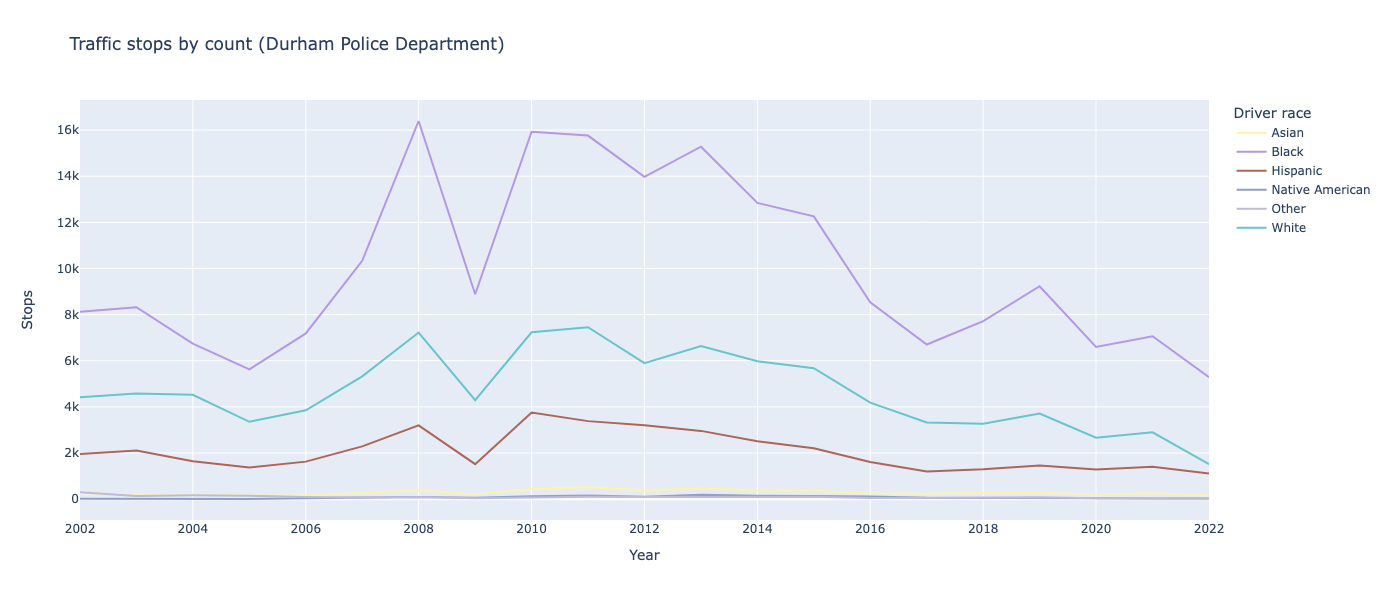

In [5]:
def traffic_stops_by_count(agency_name):
    df = pd.read_sql(
        f"""
        WITH stops AS ({get_stops_summary_sql({agency_name})})
        SELECT
            year
            , driver_race
            , count(*) AS stop_count
        FROM stops
        WHERE year > '2001-12-31'
        GROUP BY 1, 2
        """,
        pg_conn.engine,
    )
    fig = px.line(
        df,
        x="year",
        y="stop_count",
        color="driver_race",
        color_discrete_map=color_map,
        title=f"Traffic stops by count ({agency_name})",
        labels={
            "stop_count": "Stops",
            "driver_race": "Driver race",
            "year": "Year",
        },
        height=600,
    )
    fig.update_xaxes(dtick="M24")
    return fig, df
fig, _ = traffic_stops_by_count("Durham Police Department")
fig

# Figure 1: Traffic stops grouped by stop purpose

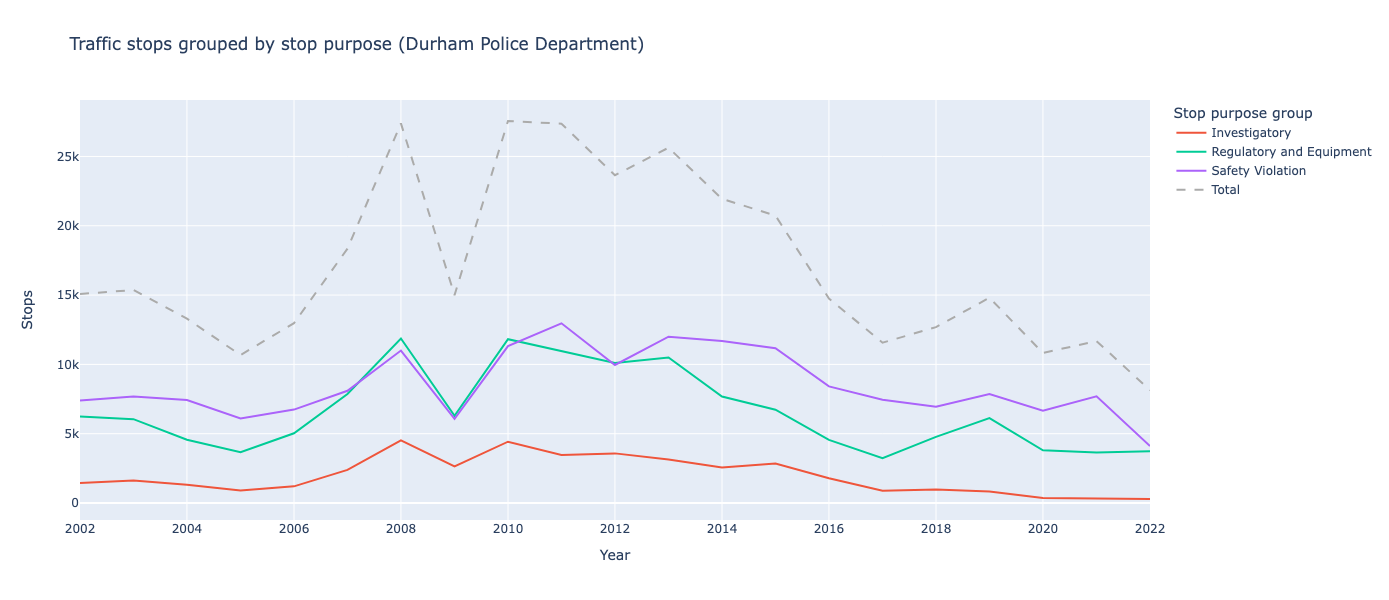

In [6]:
def traffic_stops_by_group(agency_name):
    df = pd.read_sql(
        f"""
        WITH stops AS ({get_stops_summary_sql({agency_name})})
        SELECT
            year
            , stop_purpose_group
            , count(*) AS stop_count
        FROM stops
        WHERE year > '2001-12-31'
        GROUP BY 1, 2
        ORDER BY year
        """,
        pg_conn.engine,
    )
    totals = df.groupby(['year'])['stop_count'].agg('sum').reset_index()
    totals['stop_purpose_group'] = 'Total'
    df = pd.concat([df, totals]).sort_values(['year', 'stop_purpose_group'])
    fig = px.line(
        df,
        x="year",
        y="stop_count",
        color="stop_purpose_group",
        color_discrete_map={"Total": px.colors.sequential.gray[8]},
        line_dash="stop_purpose_group",
        line_dash_map={"Total": "dash", "Investigatory": "solid", "Safety Violation": "solid", "Regulatory and Equipment": "solid"},
        title=f"Traffic stops grouped by stop purpose ({agency_name})",
        labels={
            "stop_count": "Stops",
            "stop_purpose_group": "Stop purpose group",
            "year": "Year",
        },
        height=600,
    )
    fig.update_xaxes(dtick="M24")
    return fig, df
fig, df = traffic_stops_by_group("Durham Police Department")
fig

## Figure 2: Stop purpose group percentage of stops distribution

This graph shows the percentage of total stops for each stop purpose group by agency. The Y-axis uses a logorithmic scale and values closer to the top represent more total stops (or larger jurisdictions). Values closer to the right side of each chart indicate a greater percentage of overall stops for that group. 

Some highlights:
* 81% of stops by the Mecklenburg County Sheriff's Office are Safety Violations stops
* 51% of stops by the Statesville Police Department are Regulatory and Equipment stops
* 55% of stops by the Gaston County Police Department are Regulatory and Equipment stops

In [7]:
df = pd.read_sql(
    f"""
    WITH stops AS ({get_stops_summary_sql(exclude_ids=[194])})
    SELECT
        agency
        , stop_purpose_group
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY agency)::integer AS total_agency_stops
    FROM stops
    WHERE year > '2001-12-31'
    GROUP BY 1, 2
    """,
    pg_conn.engine,
)
df["group_percent"] = df.stop_count / df.total_agency_stops

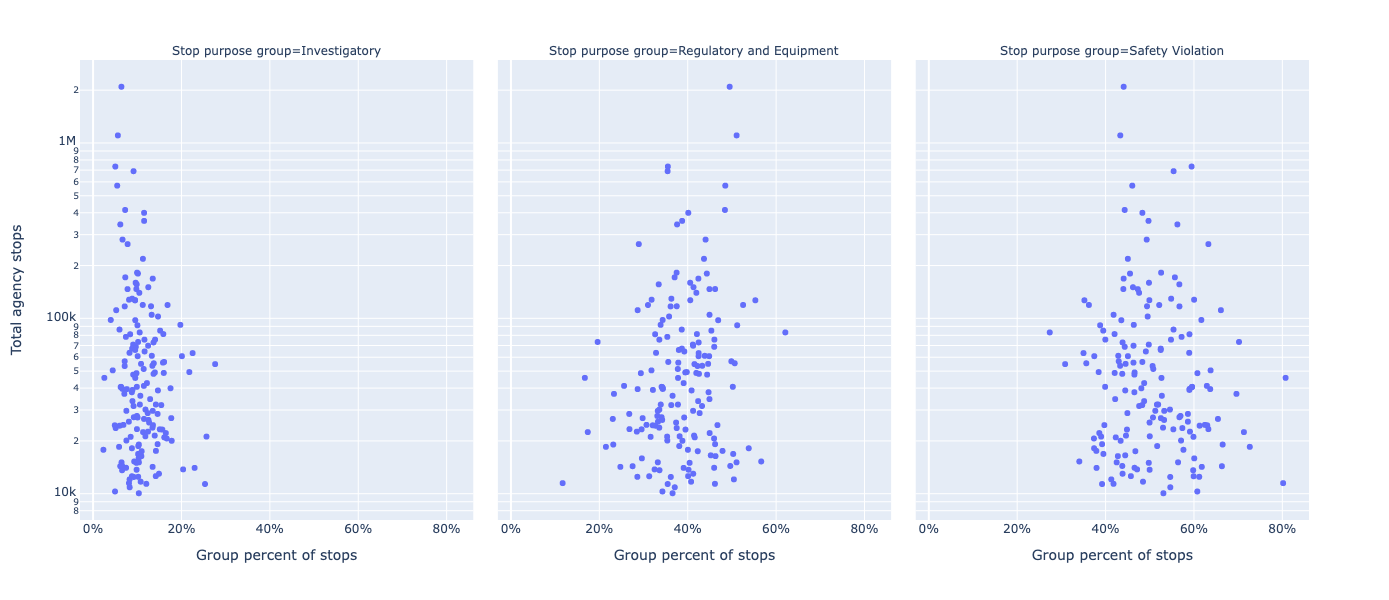

In [8]:
mask = df["total_agency_stops"] > 10000
fig = px.scatter(
    df[mask],
    x="group_percent",
    y="total_agency_stops",
    hover_data=["agency", "total_agency_stops"],
    facet_col="stop_purpose_group",
    labels={
        "stop_count": "Stops",
        "stop_purpose_group": "Stop purpose group",
        "group_percent": "Group percent of stops",
        "total_agency_stops": "Total agency stops",
        "agency": "Agency",
    },
    log_y=True,
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig.update_layout(hoverlabel_namelength=-1)
fig.show()

In [9]:
# mask = df["total_agency_stops"] > 20000
# fig = px.strip(
#     df[mask],
#     x="group_percent",
#     y="stop_purpose_group",
#     hover_data=["agency", "total_agency_stops"],
#     labels={
#         "stop_count": "Stops",
#         "stop_purpose_group": "Stop purpose group",
#         "group_percent": "Group percent of stops",
#         "total_agency_stops": "Total agency stops",
#         "agency": "Agency",
#     },
#     height=600,
# )
# fig.update_xaxes(tbickformat=",.0%")
# fig.show()

## Traffic stops grouped by stop purpose for select agencies

### Figure 3: Mecklenburg County Sheriff

The majority of Mecklenburg County Sheriff stops are for safety purposes.

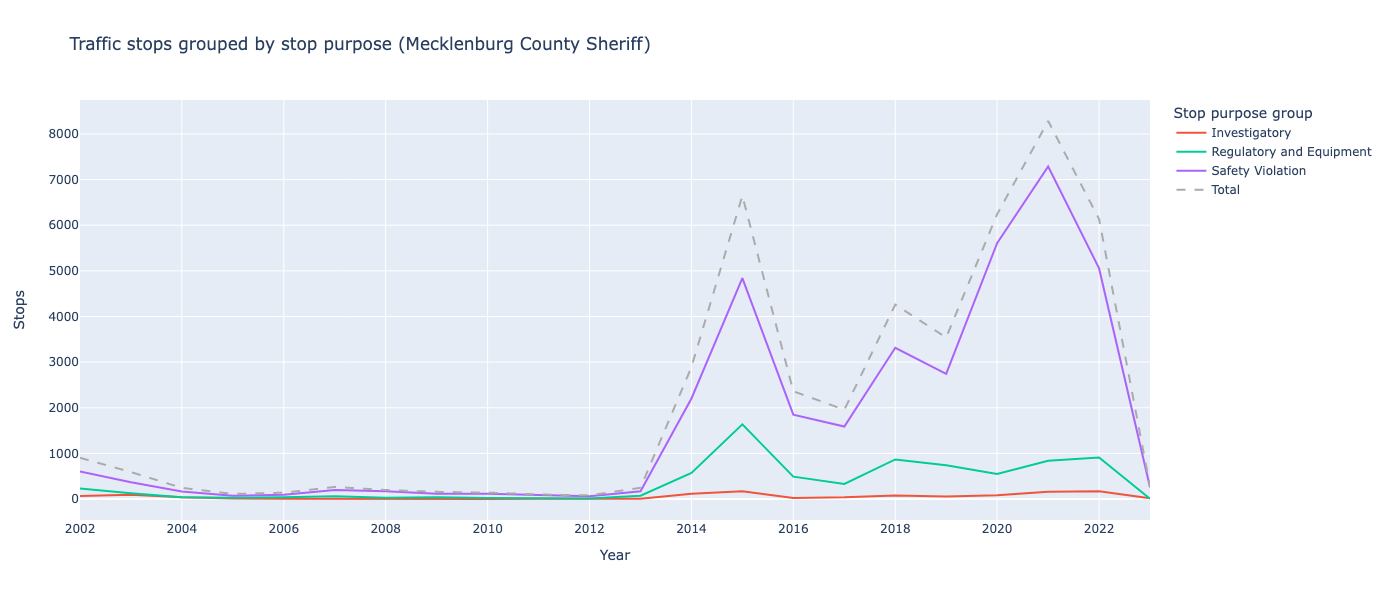

In [10]:
fig, _ = traffic_stops_by_group("Mecklenburg County Sheriff")
fig

### Figure 4: Statesville Police Department

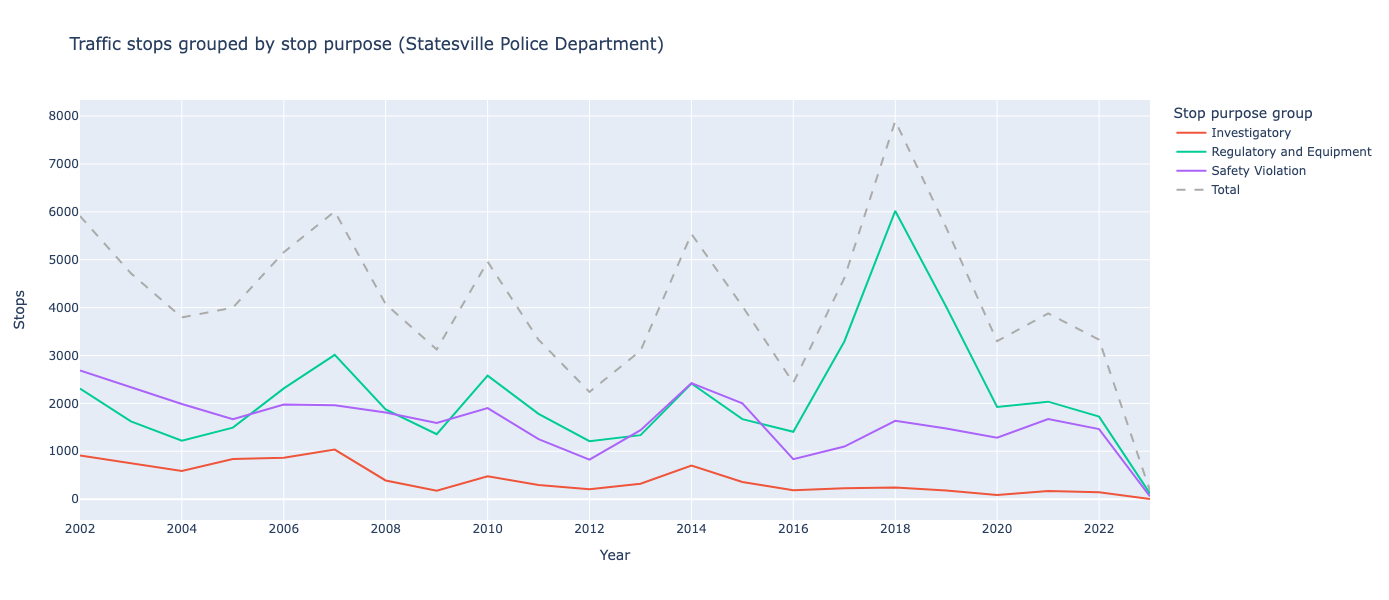

In [11]:
fig, _ = traffic_stops_by_group("Statesville Police Department")
fig

### Figure 5: Raleigh Police Department

The Raleigh Police Department generally makes more Regulatory and Equipment stops than Safety Violation stops.

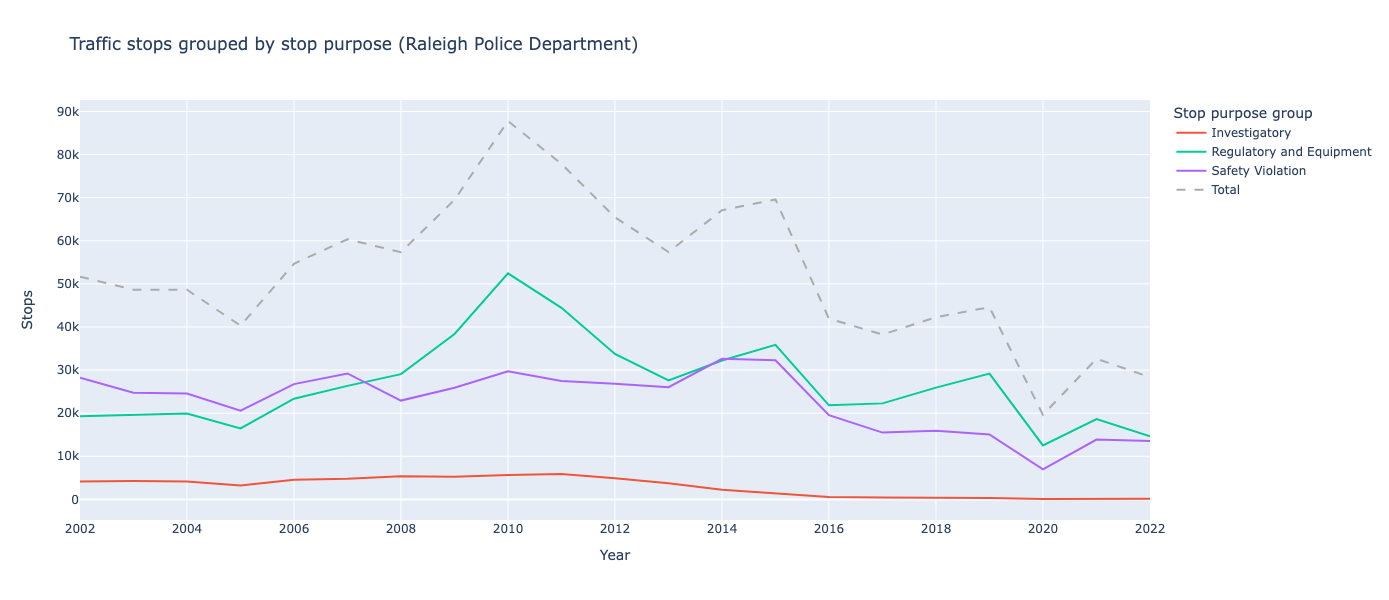

In [12]:
fig, _ = traffic_stops_by_group("Raleigh Police Department")
fig

### Figure 6: Fayetteville Police Department

The Fayetteville Police Department performed many more Safety Violation stops during Chief Medlock's tenure.

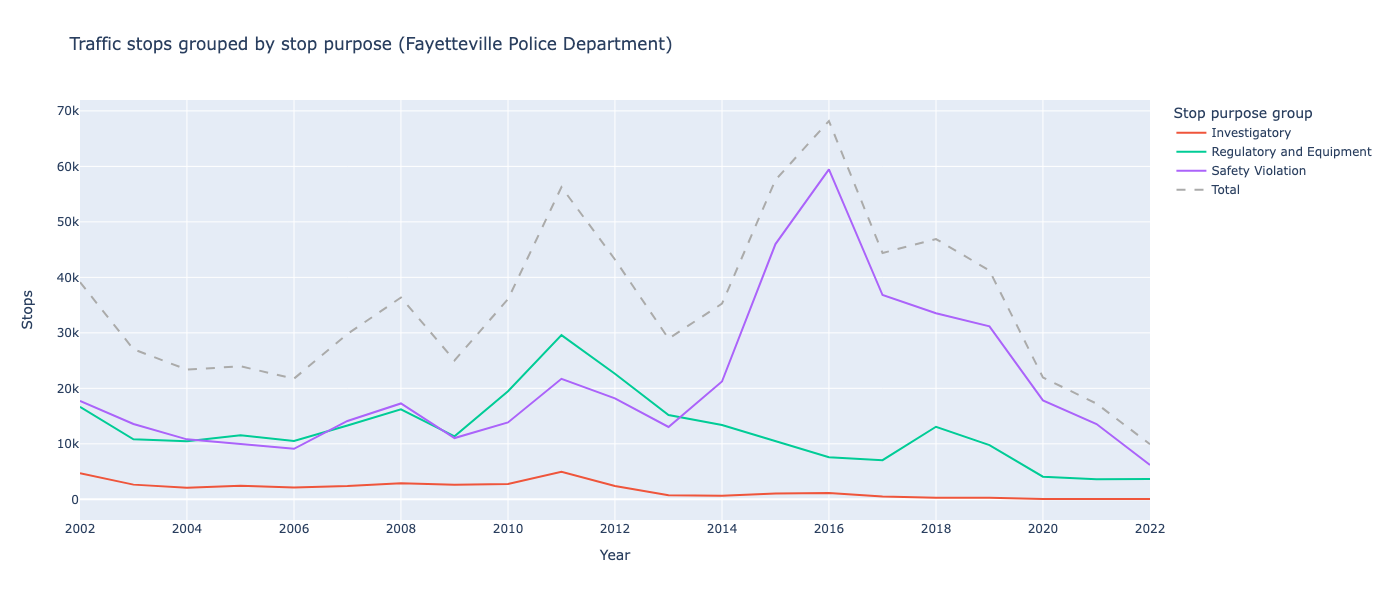

In [13]:
fig, _ = traffic_stops_by_group("Fayetteville Police Department")
fig

### Figure 7: Greensboro Police Department

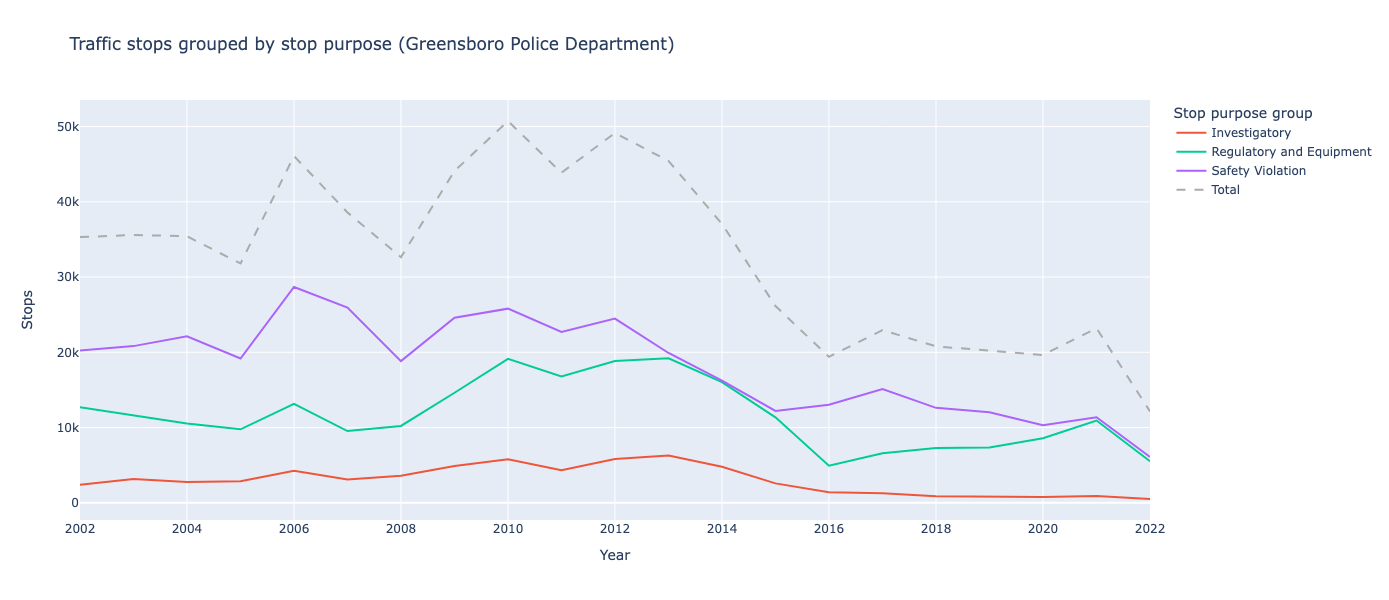

In [14]:
fig, _ = traffic_stops_by_group("Greensboro Police Department")
fig

# Traffic stops grouped by stop purpose and driver race

If we add an additional data point, driver race, to the graph, additional comparisons can be made. 

In [15]:
def traffic_stops_by_group_with_race(agency_name):
    df = pd.read_sql(
        f"""
        WITH stops AS ({get_stops_summary_sql({agency_name})})
        SELECT
            year
            , driver_race
            , stop_purpose_group
            , count(*) AS stop_count
        FROM stops
        WHERE year > '2001-12-31'
        GROUP BY 1, 2, 3
        ORDER BY year
        """,
        pg_conn.engine,
    )
    fig = px.line(
        df,
        x="year",
        y="stop_count",
        color="driver_race",
        color_discrete_map=color_map,
        category_orders={
            "stop_purpose_group": ['Safety Violation', 'Regulatory and Equipment', 'Investigatory']
        },
        facet_col="stop_purpose_group",
        facet_col_spacing=0.05,
        title=f"Traffic stops grouped by stop purpose ({agency_name})",
        labels={
            "driver_race": "Driver race",
            "stop_count": "Stops",
            "stop_purpose_group": "Stop purpose group",
            "year": "Year",
        },
        height=600,
    )
    fig.update_xaxes(dtick="M24", tickangle=45)
    return fig, df

### Figure 8: Durham Police Department

The Durham Police Department stops black drivers 2-3 times as much as white drivers for Safety Violation and Regulatory and Equipment stops.

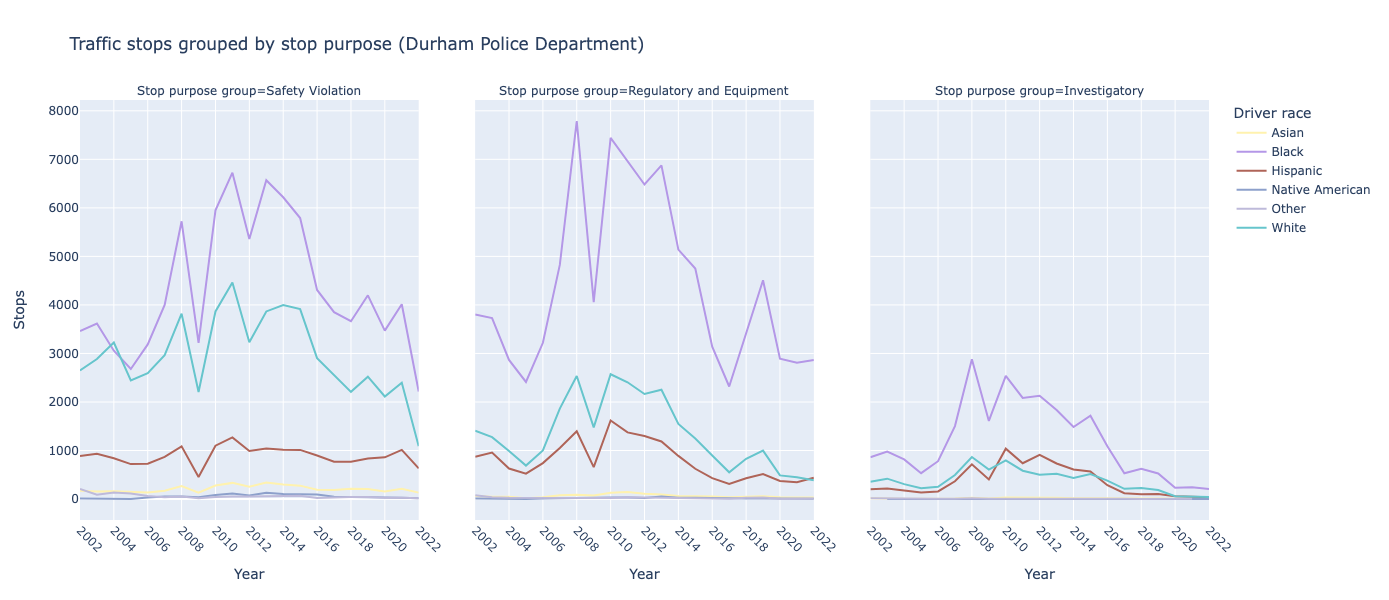

In [16]:
fig, df = traffic_stops_by_group_with_race("Durham Police Department")
fig

### Figure 9: Mecklenburg County Sheriff

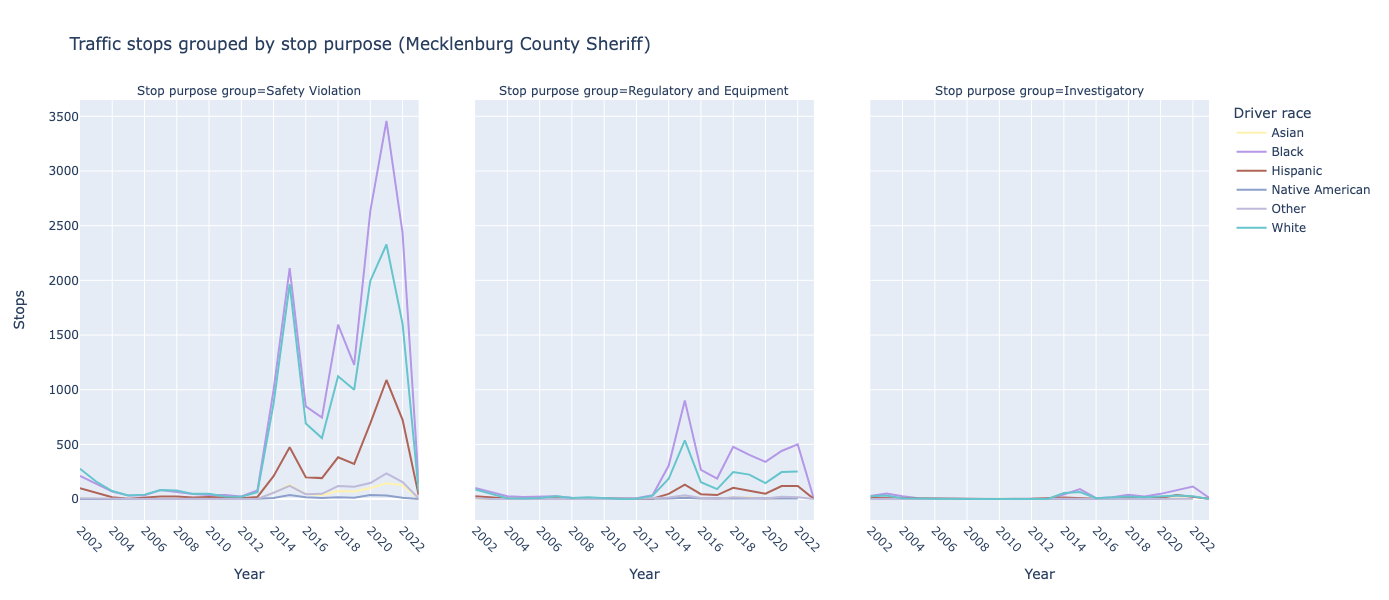

In [17]:
fig, df = traffic_stops_by_group_with_race("Mecklenburg County Sheriff")
fig

### Figure 10: Raleigh Police Department

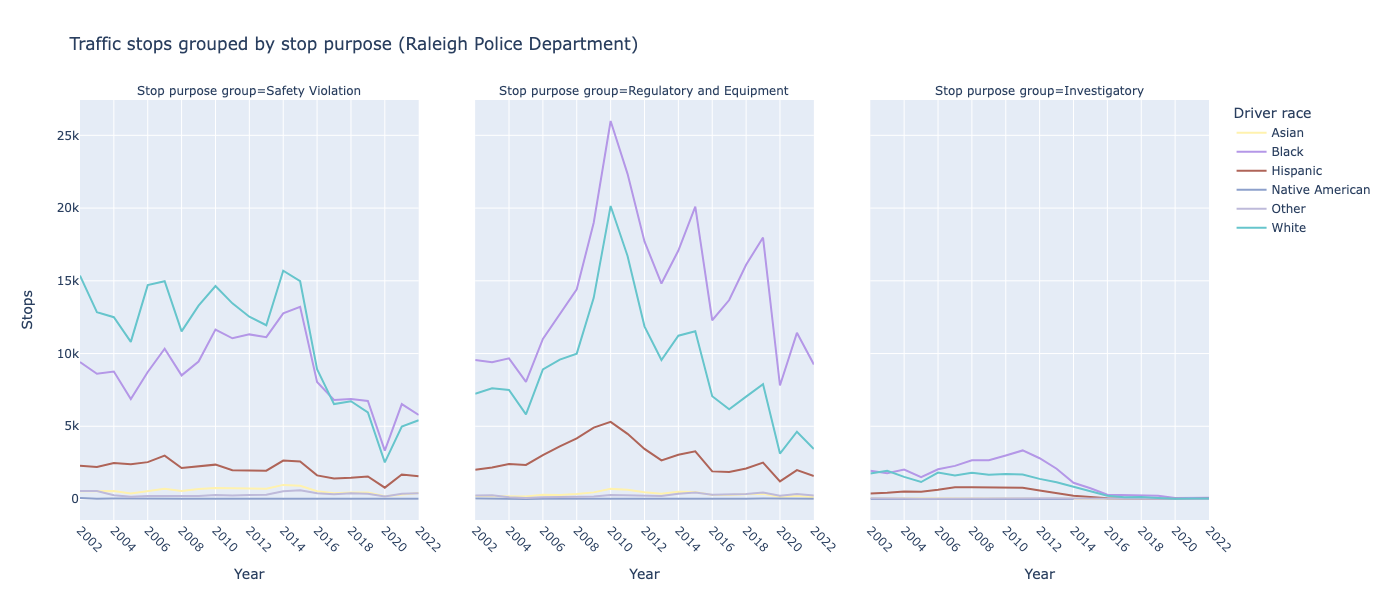

In [18]:
fig, df = traffic_stops_by_group_with_race("Raleigh Police Department")
fig

### Figure 11: Fayetteville Police Department

In [19]:
fig, _ = traffic_stops_by_group_with_race("Fayetteville Police Department")
fig

### Figure 12: Greensboro Police Department

Greensboro Police Department stops black drivers 2-3 times as much as white drivers for Regulatory and Equipment stops.

In [20]:
fig, _ = traffic_stops_by_group_with_race("Greensboro Police Department")
fig

In [21]:
!jupyter nbconvert stop-types.ipynb --to html --no-input --output=stop-types.html

[NbConvertApp] Converting notebook stop-types.ipynb to html
[NbConvertApp] Writing 4527262 bytes to stop-types.html
